In [ ]:
import torch 
from torch import nn
import matplotlib.pyplot as plt

# this code specifies whic device to use for neural net computations
# mps is the apple chip GPU, so this should speed up calculations
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


# Data
Hard code some linear data using basic weight and bias values

In [ ]:
# Create a weight and bias
weight = 0.7
bias = 0.3

# create range values
star = 0
end = 1
step = 0.02

# Create x and y (features and labels)
# The unsqueeze function creates a tensor of shape (50, 1) rather than of size (50)
# essentially, this creates a 2d tensor rather than a 1d vector
# We need to do this becuase otherwise there will be vector multiplication errors in the neural net layers
x = torch.arange(star, end, step).unsqueeze(dim=1)
y = weight * x + bias

print(x[:10], y[:10])

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]]) tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


Now We want to split the data into training and validation sets. We'll use 80% of the data for training and the remaining 20% of the data for validation / testing

In [4]:
# Split the data
train_split = int(0.8 * len(x))

x_train, y_train = x[:train_split], y[:train_split]
x_test, y_test = x[train_split:], y[train_split:]

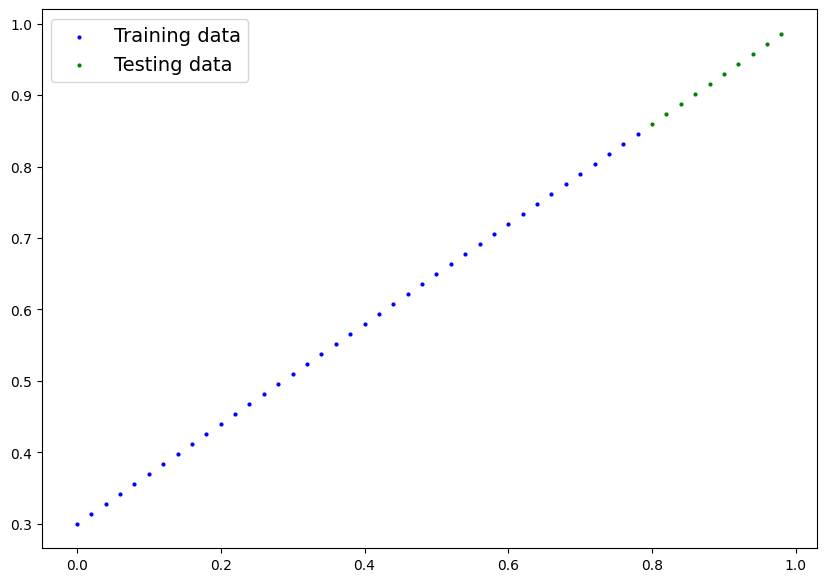

In [5]:
def plot_predictions(train_data=x_train, 
                     train_labels=y_train, 
                     test_data=x_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

plot_predictions(x_train, y_train, x_test, y_test)


# Build a PyTorch linear model
We will use the built in nn.Linear() to create the weight and bias parameters for the linear regression. So that we don't have to do it manually.

In [ ]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Use the nn.Linear() for creating the linear model parameters
        # The in and out features specify the number of dimensions that the input layer and output
        # layer should have
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
    
    # This takes in the input data and passes it through the linear layer for the output
    # at the moment, we do not have any hidden layers
    def forward(self, x):
        return self.linear_layer(x)

torch.manual_seed(42)
model = LinearRegressionModel()
print(model, model.state_dict())

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
) OrderedDict([('linear_layer.weight', tensor([[0.7645]])), ('linear_layer.bias', tensor([0.8300]))])


# Changing device type
We can change the computational device that the calculations run on by specifying the name of the device that we want the computations to run on

In [ ]:
next(model.parameters()).device

# Here we attempt to switch it to the Mac's gpu
model.to(device)
next(model.parameters()).device

device(type='mps', index=0)

# Training
Here we build our training and testing loop for the model. We first need to specify a loss function and an optimizer that should be used for calculating and executing gradient descent. 
\
\
One thing to note is that you will probably get slightly different answers depending on whether you run the calculations on the CPU vs the GPU. 

In [12]:
# According to documentation, the L1 loss function is the mean absolute error (MAE) loss function
# It calculates the absolute differenece between each output and expected output and takes the mean 
# of these differences to come up with a single loss value for a training epoch
loss_func = nn.L1Loss()

# Create an optimizer
# This optimizer is the Stochastic Gradient Descent, which we used in the other model as well
opt = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [ ]:
torch.manual_seed(42)

# Set the number of training epochs
epochs = 1000

# Since we put the device on the GPU, we also want to put the data onto the GPU
# without this, an error will happen (not all model/data on device)
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ** One thing to note is that we're not batching this data as we did in the other example
for epoch in range(epochs):
    # Put the model into training mode
    model.train()

    preds = model(x_train)
    loss = loss_func(preds, y_train)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # Put the model into inference mode
    model.eval()
    with torch.inference_mode():
        test_preds = model(x_test)

        test_loss = loss_func(test_preds, y_test)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779270172119 | Test loss: 0.5739762783050537
Epoch: 100 | Train loss: 0.006215682718902826 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 300 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 400 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 500 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 600 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 700 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 800 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 900 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904


In [14]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='mps:0')),
             ('linear_layer.bias', tensor([0.3025], device='mps:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# Making predictions
Now that we have trained our model, lets turn on it's evaluation mode and make some predictions based on some new data

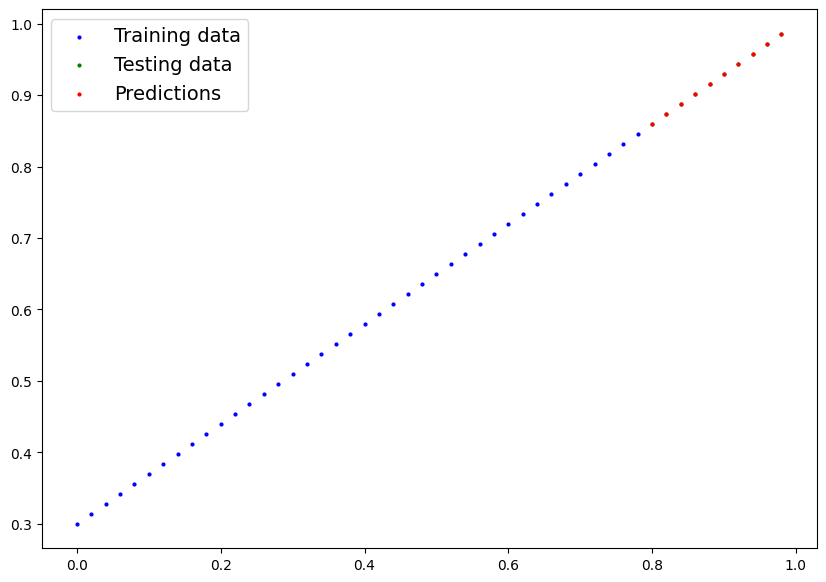

In [16]:
# Put the model into evaluation mode
model.eval()

with torch.inference_mode():
    y_preds = model(x_test)

# print(y_preds)

# Many data science libraries like numpy and matplotlib can't use data that is stored
# on the GPU. Therefore, since we ran these calculations on the GPU, we have to convert them
# over to our CPU in order to make plots and do other sorts of data analysis on it
plot_predictions(predictions=y_preds.cpu())